In [40]:
import numpy as np
import math
import matplotlib.pyplot as plt
import time
%load_ext autoreload
%autoreload 2
%matplotlib inline
%matplotlib inline

import math



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Scale Invariant Feature Transform

Ref: https://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf
Ref: https://www.dropbox.com/sh/26xgy96py8itk14/AABhgCbYzraeSMkDpjY92kFVa/Lecture%20slides?dl=0&preview=2017f.Week10.Topic15.lecture.sift.pdf&subfolder_nav_tracking=1
Ref: https://cs.nyu.edu/~fergus/teaching/vision_2012/3_Corners_Blobs_Descriptors.pdf
Ref: https://arxiv.org/pdf/1603.09114.pdf

## Image processing / filtering / gradients

In [41]:
def GaussianFilter(w,h,sigma):
    m = (w-1)/2
    n = (h-1)/2
    G = []
    for i in range(w):
        for j in range(h):
            G.append((1/(2*math.pi*sigma**2))*math.e**(-1*((i-m)**2+(j-n)**2)/(2*sigma**2)))
    
    return np.array(G).reshape(w,h)/np.sum(np.array(G))

def get_im2col_indices_blur(x_shape, field_height, field_width, p_x=1,p_y=1, stride=1):
    # First figure out what the size of the output should be
    _, C, H, W = x_shape
    assert (H + 2 * p_x - field_height) % stride == 0
    assert (W + 2 * p_y - field_height) % stride == 0
    out_height = int((H + 2 * p_x - field_height) / stride + 1)
    out_width = int((W + 2 * p_y - field_width) / stride + 1)

    i0 = np.repeat(np.arange(field_height), field_width)
    i0 = np.tile(i0, C)
    i1 = stride * np.repeat(np.arange(out_height), out_width)
    j0 = np.tile(np.arange(field_width), field_height * C)
    j1 = stride * np.tile(np.arange(out_width), out_height)
    i = i0.reshape(-1, 1) + i1.reshape(1, -1)
    j = j0.reshape(-1, 1) + j1.reshape(1, -1)

    k = np.repeat(np.arange(C), field_height * field_width).reshape(-1, 1)

    return (k, i, j)

def blur(im,sigma,k,h,w,stride=1,C=3):
    H,W = im.shape
    g = GaussianFilter(h,w,k*sigma).flatten()
    #g = np.tile(g,C)
    
    stride=1
    h_pad = int((H*(stride-1)-stride+h)/2)
    w_pad = int((W*(stride-1)-stride+w)/2)
    
    k,i,j = get_im2col_indices_blur((1,1,H,W), h, w, p_x=h_pad,p_y=w_pad, stride=1)
    
    im_padded = np.pad(im,((h_pad,h_pad),(w_pad,w_pad)),'mean')
    cols = im_padded[i,j]

    return cols.T.dot(g).reshape(H,W)

In [42]:
def grad(direct):
    if direct=='x':
        g = np.array([[0,0,0],[-1,0,1],[0,0,0]])
    if direct=='y':
        g = np.array([[0,-1,0],[0,0,0],[0,1,0]])
    if direct =='mod':
        g = np.array([[0,-1,0],[-1,0,1],[0,1,0]])
    if direct =='xy':
        gx = np.array([[0,0,0],[-1,0,1],[0,0,0]])
        gy = np.array([[0,-1,0],[0,0,0],[0,1,0]])
        g = (gx,gy)
        
    return g
        

In [43]:
def conv2d(im,gauss=False,type_='mod',stride=1,**kwargs):
    h=3
    w=3
    H,W = im.shape
    
    if gauss==True:
        sigma = kwargs['sigma']
        h_g,w_g = kwargs['g']
        
        im = blur(im,sigma,1,h_g,w_g,stride=1,C=3)

    gs = grad(type_)
    sol = []
    for g in gs:
        stride=1

        h_pad = int((H*(stride-1)-stride+h)/2)
        w_pad = int((W*(stride-1)-stride+w)/2)

        k,i,j = get_im2col_indices_blur((1,1,H,W), h, w, p_x=h_pad,p_y=w_pad, stride=1)

        im_padded = np.pad(im,((h_pad,h_pad),(w_pad,w_pad)),'constant')
        cols = im_padded[i,j]

        sol.append(cols.T.dot(g.flatten()).reshape(H,W))
    return sol

## Pyramid of DOG images:
$$D(x,y,\rho) = I(x,y)*(G(x,y,k\rho) - G(x,y,\rho))$$
for $$\rho=\sigma.k\sigma,k^2\sigma,...,k^{s-1}\sigma$$

In [44]:
def octave(im,RE,sigma=1.6,s=4):
    #beg = time.time()
    if s<=5:
        #sigma *=RE+1
        
        if RE>=1:
            im = blur(im,sigma,2,h=11,w=11)
            im = Reduce(im,RE)
        
        k = 2**(1/s)
        G5 = blur(im,sigma,k**5,h=11,w=11)
        G4 = blur(im,sigma,k**4,h=11,w=11)
        G3 = blur(im,sigma,k**3,h=11,w=11)
        G2 = blur(im,sigma,k**2,h=11,w=11)
        G1 = blur(im,sigma,k**1,h=11,w=11)
        G0 = blur(im,sigma,k**0,h=11,w=11)


        L5= Expand(G5 - G4,RE)
        L4= Expand(G4 - G3,RE)
        L3= Expand(G3 - G2,RE)
        L2= Expand(G2-G1,RE)
        L1= Expand(G1 - G0,RE)
        #end = time.time()
        #print('Octave execution time: {}'.format(end-beg))
        sigma_ = np.power(k,np.arange(0,s))*sigma
        return np.stack((L1,L2,L3,L4,L5)),[np.stack((L1,L2,L3)),np.stack((L2,L3,L4))],sigma_
    else:
        sigma*=RE+1
        H,W = im.shape
        L = np.zeros((s,H,W))
        
        
        
        im = Reduce(im,RE)
        H,W = im.shape
        k = 2**(1/s)
        G = np.zeros((s+1,H,W))
        
        
        for i in range(s+1):
            G[i,:,:] = blur(im,sigma,k**i,h=11,w=11)
        for i in range(s):
            L[i,:,:] = Expand(G[i+1,:,:]-G[i,:,:],RE)
        sigma_ = np.power(k,np.arange(0,s))*sigma
        return L,[L[:3,:,:],L[1:4,:,:]],sigma_
        

## Detecting DOG extrema

Find all pixels that correspond to extrema of $D(x,y,\rho)$. For each $(x,y,\rho)$, check wether $D(x,y,\rho)$ is greater than (or smaller than) all of its neighbours in current scale and adjacent scales above & below.

In [45]:
def get_im2col_indices_conv2d_max(x_shape, field_height, field_width, p_x=1,p_y=1, stride=1):
    # First figure out what the size of the output should be
    N, C, H, W = x_shape
    assert (H + 2 * p_x - field_height) % stride == 0
    assert (W + 2 * p_y - field_height) % stride == 0
    out_height = int((H + 2 * p_x - field_height) / stride + 1)
    out_width = int((W + 2 * p_y - field_width) / stride + 1)

    i0 = np.repeat(np.arange(field_height), field_width)
    i0 = np.tile(i0, C)
    i1 = stride * np.repeat(np.arange(out_height), out_width)
    j0 = np.tile(np.arange(field_width), field_height * C)
    j1 = stride * np.tile(np.arange(out_width), out_height)
    i = i0.reshape(-1, 1) + i1.reshape(1, -1)
    j = j0.reshape(-1, 1) + j1.reshape(1, -1)

    k = np.repeat(np.arange(C), field_height * field_width).reshape(-1, 1)

    return (k, i, j)

In [46]:
def conv2d_max(f,g,k=1,**kwargs):
    #f = f[:,np.newaxis,:,:]
    #f = np.repeat(f,3,axis=1)
    
    N,H,W=f.shape

    n = np.tile(np.arange(3),N-2) + np.repeat(np.arange(N-2),3)
    f = f[n,:,:].reshape((N-2,3,H,W))
    
    N,C,H,W = f.shape
    h,w = g

    x_pad = int(0.5*((W-1)*1-W+w))
    y_pad = int(0.5*((H-1)*1-H+w))

    f_pad = np.pad(f,((0,0),(0,0),(x_pad,x_pad),(y_pad,y_pad)),mode='maximum')

    k,i,j = get_im2col_indices_conv2d_max((N,C,H,W), h, w, p_x=x_pad,p_y=y_pad, stride=1)

    cols = f_pad[:,k,i,j]
       
    xc = int((h*w-1)/2) 
    cols = np.delete(cols,(xc,xc+h*w,xc+2*h*w),1)
    
    cond = ((f[:,1,:,:].flatten() > 
             np.max(cols,axis=1).flatten())|(f[:,1,:,:].flatten() < 
                                   np.min(cols,axis=1).flatten()))&(np.abs(f[:,1,:,:].flatten())>0.03)

    return cond.reshape(N,H,W).T,cond

## Refining location of Extrema
2nd order taylor expansion of D at $(x,y,\rho)$:
$$D\left(\Delta\vec{x}^{\,}\right) = D(\vec{x}^{\,}) +\left(\frac{\partial D}{\partial \vec{x}^{\,}}\right)^T\Delta\vec{x}^{\,} + \frac{1}{2}\left(\Delta\vec{x}^{\,}\right)^T\frac{\partial^2 D}{\partial \vec{x}^{\,2}}\left(\Delta\vec{x}^{\,}\right)$$
Gradient wrt $\Delta\vec{x}^{\,}$:
$$\frac{\partial D}{\partial \Delta\vec{x}^{\,} } = \left(\frac{\partial D}{\partial \vec{x}^{\,}}\right) + \frac{\partial^2 D}{\partial \vec{x}^{\,2}}\left(\Delta\vec{x}^{\,}\right)$$
Minimum occurs when $\frac{\partial D}{\partial \Delta\vec{x}^{\,} }=0$
$$\Delta\vec{x}^{\,}  = - \left(\frac{\partial^2 D}{\partial \vec{x}^{\,2}}^{-1}\right)\left(\frac{\partial D}{\partial \vec{x}^{\,}}\right)$$

All gradients estimated using finite differences


In [47]:
def get_deriv(pyr,kp):
    print(pyr.shape)
    z = kp[2,:].astype(int)
    y = kp[0,:].astype(int)+1
    x = kp[1,:].astype(int)+1

    pyr = np.pad(pyr,((0,0),(1,1),(1,1)),'maximum')


    Ix = pyr[z,x+1,y] - pyr[z,x-1,y]
    Iy = pyr[z,x,y+1] - pyr[z,x,y-1]
    Is = pyr[z+1,x,y] - pyr[z-1,x,y]
    Ixy = pyr[z,x+1,y+1] - pyr[z,x-1,y-1]
    
    #H = np.array([[Ix,Ixy],[Ixy,Iy]])

    Ixx = pyr[z,x+1,y] - 2*pyr[z,x,y] + pyr[z,x-1,y]
    Iyy = pyr[z,x,y+1] - 2*pyr[z,x,y] + pyr[z,x,y-1]
    Iss = pyr[z+1,x,y] - 2*pyr[z,x,y] + pyr[z-1,x,y]
    Ixxyy = pyr[z,x+1,y+1] - 2*pyr[z,x,y] + pyr[z,x-1,y-1]
    Ixxss = pyr[z+1,x+1,y] - 2*pyr[z,x,y] + pyr[z-1,x-1,y]
    Iyyss = pyr[z+1,x,y+1] - 2*pyr[z,x,y] + pyr[z-1,x,y-1]
    
    H = np.array([[Ixx,Ixxyy,Ixxss],[Ixxyy,Iyy,Iyyss],[Ixxss,Iyyss,Iss]])
    J = np.array([[Ix**2,Ix*Iy],[Ix*Iy,Iy**2]])
    dx = np.array([Ix,Iy,Is])
    return H,dx,J

## Compute new locations and prune insignificant extrema:

Find the Hessian for each key point and prune if $\frac{Tr^2(H)}{Det(H)}>(1.1)^2$.

Look for Harris Corner detector to understand this

def harris(im,kp):
    Ix,Iy = conv2d(im,gauss=False,type_='xy',stride=1)
    Ixs = np.sum(get_patch2(Ix,kp,h=3,w=3),axis=(0,1))
    Iys = np.sum(get_patch2(Iy,kp,h=3,w=3),axis=(0,1))
    H = np.array([[Ixs**2,Ixs*Iys],[Ixs*Iys,Iys**2]])
    tr = np.trace(H)**2
    det = np.linalg.det(np.moveaxis(H,2,0))
    #R = det - 0.04*tr
    corners = np.divide(tr,det,out=np.zeros_like(tr),where=det!=0)>(1.1)**2
    #corners = R>0
    return corners
    

In [48]:
def build_sig(xk,sigma):
    sig = np.zeros(xk.shape[0])
    k=0
    for i in xk:
        sig[k] = sigma[i[2]]
        k+=1
    return np.vstack((xk.T,sig))
    

In [49]:
def harris(octa,xk):
    xk = xk.T
    imX = np.pad(octa,((0,0),(1,1),(1,1)),'mean')

    j = xk[0,:].astype(int)+1
    i = xk[1,:].astype(int)+1

    Dxx = imX[xk[2,:].astype(int),i+1,j] - imX[xk[2,:].astype(int),i-1,j]
    Dyy = imX[xk[2,:].astype(int),i,j+1] - imX[xk[2,:].astype(int),i,j-1]

    H=np.array([[Dxx**2,Dxx*Dyy],[Dxx*Dyy,Dyy**2]])
    tr = np.trace(H)**2
    det = np.linalg.det(np.moveaxis(H,2,0))
    
    #R = det - 0.04*tr
    return np.divide(tr,det,out=np.zeros_like(tr),where=det!=0)<(1.1)**2

In [50]:
def refine_location_prune(im,pyr,kp):
    #pyr = pyramid[0]
    H,dx,J = get_deriv(pyr,kp)

    U,S,V = np.linalg.svd(np.moveaxis(H,2,0))
    S = S[:,:,np.newaxis]*np.diag(np.ones(3))
    A = np.linalg.inv(S)
    H_inv = np.matmul(np.matmul(A,S),V)
    deltas = np.squeeze(np.matmul(H_inv,np.moveaxis(dx,1,0)[:,:,np.newaxis]))
    

    if kp.shape[1]!=0:
        keep = harris(pyr,kp.T)
        return (deltas,keep)
    else:
        return (deltas,None)
    #return (deltas,None)

## Keypoint orientation assignment
 Contribution to the bin is: $$\left|\nabla I(x,y)\right|G_{1.5\rho_i}(d)$$

In [51]:
def HOG(im,kp):
    Ix,Iy = conv2d(im,gauss=False,type_='xy',stride=1,**{'sigma':1,'g':(3,3)})
    #kp[3,:] *=1.5
    Ixs = get_patch2(Ix,kp.T,h=9,w=9)
    Iys = get_patch2(Iy,kp.T,h=9,w=9)
    Imag = np.sqrt(Ixs**2+Iys**2)
    #orient = np.abs(np.arctan2(Iys,Ixs))
    orient = np.arctan2(Iys,Ixs)
    orient[orient<0]+=2*math.pi


    #bins = np.arange(0,170,10)*math.pi/180
    bins = np.arange(0,360,10)*math.pi/180
    
    hist=[]
    for k in range(Imag.shape[2]):
        P = orient[:,:,k]
        D = Imag[:,:,k]


        O = np.argmin((P[:,:,np.newaxis]-bins)**2,axis=2).astype(int)

        count = np.zeros_like(bins)

        for i in range(P.shape[0]):
            for j in range(P.shape[1]):
                count[O[i,j]]+=D[i,j]

        hist.append(np.argmax(count))
    hist =np.hstack(hist)
    
    return np.array([bins[i] for i in hist])*180/math.pi

In [52]:
 #GaussianFilter(16,16,xk[3,i]/2)

# SIFT descriptor

In [63]:
def features(patches,xk):
    
    Imag = []
    Irho = []
    for i in range(patches.shape[-1]):
        Ix,Iy = conv2d(patches[:,:,i],gauss=False,type_='xy',stride=1)
        Imag.append(np.sqrt(Ix**2+Iy**2))
        Irho.append(np.arctan2(Iy,Ix))
        
    Imag = split_tensor(np.moveaxis(np.stack(Imag),0,2))
    Irho = split_tensor(np.moveaxis(np.stack(Irho),0,2))
    Irho[Irho<0] = Irho[Irho<0] + 2*math.pi
    Irho *= 180/math.pi
    Irho -= xk[4,:]
    
    Irho[Irho<0]+=360
    
    bins = np.arange(0,360,45)##hist =np.hstack(hist)*math.pi/180

    fks=[]
    for k in range(Imag.shape[-1]):
        contrib = np.zeros_like(bin)
        W = GaussianFilter(16,16,xk[3,i]/2)
        W = split_matrix(W)
        count = np.zeros_like(bins)
        fk=[]
        for p in range(Imag.shape[-2]):
            P = Irho[:,:,p,k]
            D = Imag[:,:,p,k]#*W[:,:,p]

            O = np.argmin((P[:,:,np.newaxis]-bins)**2,axis=2).astype(int)


            for i in range(P.shape[0]):
                for j in range(P.shape[1]):
                    
                    count[O[i,j]]+=D[i,j]

            fk.append(count)
        
        
        fk = np.hstack(fk)
        fk_mod = np.sqrt(fk.dot(fk))
        
        if fk_mod==0:
            fks.append(fk)
        else:
            fk = np.clip(fk/fk_mod,None,0.2)
            fk_mod = fk.dot(fk)
            if fk_mod==0:
                fks.append(fk)
            fks.append(np.clip(fk/np.sqrt(fk_mod),None,0.2))
            
    
        
    return np.stack(fks)

# Help functions

In [54]:
def get_patch2(im,kp,h=9,w=9):
    
    kp = kp.T
    
    h_ = int((h-1)/2)+1
    w_ = int((w-1)/2)+1
    im = np.pad(im,((h_,h_),(w_,w_)),'mean')
    mypks=kp[:2].astype(int).T
    
    patches=[]
    count=0
    for i in mypks:
       
        p = im[i[1]:i[1]+h,i[0]:i[0]+w]
        p = blur(p,kp[3,count],1,3,3,stride=1,C=3)

        #g = GaussianFilter(h,w,kp[3,count])
        
        #patches.append(p*g)
        patches.append(p)
        count+=1
        if p.shape[0]==0:
            print('patchw/ zero shape on kp {}'.format(i))
    return np.dstack(patches)

In [55]:
def split_tensor(A):
    x = (np.tile(np.tile(np.arange(4),16) + np.repeat(np.arange(0,14,4),16),4).reshape((4,-1)).T).astype(int)
    y = (np.tile(np.repeat(np.arange(0,14,4),4),4)[:,np.newaxis]+np.arange(4)).astype(int)

    k = A.shape[2]

    z = (np.repeat(np.zeros((64,4)),k).reshape((64,4,-1)) + np.arange(k)).astype(int)
    x = np.repeat(x[:,:,np.newaxis],k,axis=2) 
    y= np.repeat(y[:,:,np.newaxis],k,axis=2)


    return np.dstack(np.split(A[x,y,z],16)).reshape((4,4,16,-1))



In [56]:
def split_matrix(A):
    x = (np.tile(np.tile(np.arange(4),16) + np.repeat(np.arange(0,14,4),16),4).reshape((4,-1)).T).astype(int)
    y = (np.tile(np.repeat(np.arange(0,14,4),4),4)[:,np.newaxis]+np.arange(4)).astype(int)
    return np.dstack(np.split(A[x,y],16))

In [57]:
def Expand(im,k):       
    for j in range(k):
        H,W = im.shape
        Ex = np.zeros((2*H-H%2,H))
        Ex[np.arange(0,2*H-H%2,2,dtype=int),np.arange(H,dtype=int)]=1

        Ey = np.zeros(((2*W-W%2),W))
        Ey[np.arange(0,2*W-W%2,2,dtype=int),np.arange(W)]=1
        im = (Ex.dot(im)).dot(Ey.T)       
    return im

In [58]:
def Reduce(im,k):   
    for j in range(k):
        H,W = im.shape

        Dx = np.zeros((int((H+H%2)/2),H))
        Dx[np.arange(int((H+H%2)/2)),np.arange(0,H,2)]=1

        Dy = np.zeros((int((W+W%2)/2),W))
        Dy[np.arange(int((W+W%2)/2)),np.arange(0,W,2)]=1
        im = (Dx.dot(im)).dot(Dy.T)
    return im

## Scale Invariant Feature Transform - SIFT

im1 = plt.imread('img/canny.jpeg')
im1 = np.mean(im1,axis=2)
H,W = im1.shape

if (H>1000)|(W>1000):
    im = Reduce(im,4)
Red=1
std=1
s=5
octa,stacks,sigma = octave(im1,Red,sigma=std,s=s)
xk,cond = conv2d_max(octa,(3,3))
xk = np.argwhere(xk)
sig = np.repeat(sigma[1:-1],H*W)[cond]
xk = np.vstack((xk.T,sig))
xk[2,:]=np.repeat(np.arange(s-2)+1,H*W)[cond]
deltas,keep = refine_location_prune(im1,octa,xk)

In [64]:
def SIFT(im,s=4,N=3,std=0.6,plot=False,display=False,shrink=2):
    
    H,W = im.shape
    im=im/255
    if (H>1000)|(W>1000):
        im = Reduce(im,shrink)
        
    H,W = im.shape

    Red=0
    kp =[]
    delt = []

    for i in range(N):

        if display==True: print('Octave: {}'.format(np.round(Red,2)))
        octa,stacks,sigma = octave(im,Red,sigma=std,s=s)
        xk,cond = conv2d_max(octa,(3,3))
        xk = np.argwhere(xk)
        #xk = build_sig(xk,sigma)

        sig = np.repeat(sigma[1:-1],H*W)[cond]
        xk = np.vstack((xk.T,sig))
        xk[2,:]=np.repeat(np.arange(s-2)+1,H*W)[cond]    
       
        #xk = xk.T[(xk[2,:]!=0)&(xk[2,:]!=s-1)]
        if display==True: print('Total of {} kps for a scale equal to  {}'.format(xk.shape[1],np.round(sigma,2)))
        deltas,keep = refine_location_prune(im,octa,xk)
        if display==True: print('Remaining kps after prunning: {}'.format(np.sum(keep)))
        xk=xk.T[keep,:]
        if xk.shape[1]!=0:
            kp.append(xk)
            delt.append(deltas[keep,:])
        Red+=1
        std*=2
    

    xk = np.vstack(kp)
    
    if xk.shape[0]==0:
        print('Zero kp found')
        return None,None
    
    
    rho = HOG(im,xk.T)
    xk = np.vstack((xk.T,rho))
    deltas = np.vstack(delt)
    
    

    patches = get_patch2(im,xk.T,h=16,w=16)
    print('imMax',im.max())
    print("Patches",patches.shape)

    fk = features(patches,xk)
    print(fk)
    
        
    if plot==True:
        plt.imshow(im,**{'cmap':'gray'})
        plt.scatter(xk[0,:],xk[1,:],color='red',s=0.5)
        plt.show()
    
    #xk[:3,:]+=deltas.T
    return xk,fk

## Match features, for the matching algorithim

In [60]:
def match(fk1,fk2,xk2,xk1,shrink,crt=0.8):
    fk=fk1
    count=0
    idx2 = []
    idx1= []
    phi_ = []
    for i in range(fk.shape[0]):
        v = fk[i]
        d = np.sum((fk2-v)**2,axis=1)
        
        f1,f2 = np.argsort(d)[:2]
        if np.sum((v - fk2[f2])**2)==0:
            continue
        
        phi = np.sum((v - fk2[f1])**2)/np.sum((v - fk2[f2])**2)
        if phi < crt:
            idx2.append(f1)
            idx1.append(i)
            phi_.append(phi)
            
    
    return (xk1[:,idx1],xk2[:,idx2]),np.array(phi_)


In [65]:
def imgMatch(N=4,s=5,std=0.3,num=10,shrink=3,crt=0.8,path1="img/template.jpg",path2="img/find.jpg"):
    print('Image 1:')
    im1 = plt.imread(path1)
    im1 = np.mean(im1,axis=2)

    xk1,fk1 = SIFT(im1,N=N,s=s,std=std,shrink=shrink,plot=True,display=True)
    print('\nImage 2:')
    im2 = plt.imread(path2)
    im2 = np.mean(im2,axis=2)
    xk2,fk2 = SIFT(im2,N=N,s=s,std=std,shrink=shrink,plot=True,display=True)
    print('fks',fk1.shape,fk2.shape)
      
    
    if (xk2.shape[0]==None):
        return None,None,None,None
    if (xk1.shape[0]==None):
        return None,None,None,None
    
    remove = np.sum(fk1,axis=1)!=0
    fk1=fk1[remove]
    xk1=xk1[:,remove]
    remove = np.sum(fk2,axis=1)!=0
    fk2=fk2[remove]
    xk2=xk2[:,remove]
    
    print('fks',fk1.shape,fk2.shape)
    
    print('\nMatches:')
    pairs,phi = match(fk1,fk2,xk2,xk1,shrink,crt)
    

    
    H,W = im1.shape
    if (H>1000)|(W>1000):
        im1 = Reduce(im1,shrink)
        
    H,W = im2.shape
    if (H>1000)|(W>1000):
        im2 = Reduce(im2,shrink)
        
    idx = np.argsort(phi)
    
    if num=='max':
        num = len(idx)
    plt.imshow(im1*255,**{'cmap':'gray'})

    plt.scatter(pairs[0][:,idx[:num]][0],pairs[0][:,idx[:num]][1],color='red',s=2)
    plt.show()
    
    plt.imshow(im2*255,**{'cmap':'gray'})

    plt.scatter(pairs[1][:,idx[:num]][0],pairs[1][:,idx[:num]][1],color='red',s=2)
    plt.show()
    return fk1,xk1,fk2,xk2,pairs,phi

Image 1:
Octave: 0
Octashape: (5, 200, 300)
sigma (5,)
HW 180000
cond (180000,)
Total of 3238 kps for a scale equal to  [0.4  0.46 0.53 0.61 0.7 ]
(5, 200, 300)
Remaining kps after prunning: 1620
Octave: 1
Octashape: (5, 200, 300)
sigma (5,)
HW 180000
cond (180000,)
Total of 6 kps for a scale equal to  [0.8  0.92 1.06 1.21 1.39]
(5, 200, 300)
Remaining kps after prunning: 6
imMax 1.0
Patches (16, 16, 1626)
[[0.         0.         0.2        ... 0.         0.         0.        ]
 [0.         0.         0.2        ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.1767767  0.         0.        ]
 ...
 [0.         0.14433757 0.         ... 0.14433757 0.         0.14433757]
 [0.         0.14433757 0.         ... 0.14433757 0.         0.14433757]
 [0.         0.14433757 0.         ... 0.14433757 0.         0.14433757]]


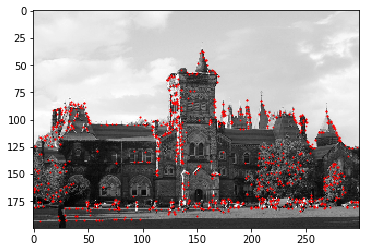


Image 2:
Octave: 0
Octashape: (5, 380, 620)
sigma (5,)
HW 706800
cond (706800,)
Total of 1159 kps for a scale equal to  [0.4  0.46 0.53 0.61 0.7 ]
(5, 380, 620)
Remaining kps after prunning: 599
Octave: 1
Octashape: (5, 380, 620)
sigma (5,)
HW 706800
cond (706800,)
Total of 4 kps for a scale equal to  [0.8  0.92 1.06 1.21 1.39]
(5, 380, 620)
Remaining kps after prunning: 4
imMax 0.9764705882352941
Patches (16, 16, 603)
[[0.         0.         0.         ... 0.         0.2        0.        ]
 [0.         0.         0.         ... 0.         0.2        0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.14433757 ... 0.         0.14433757 0.        ]
 [0.         0.         0.1767767  ... 0.         0.         0.        ]
 [0.         0.         0.1767767  ... 0.         0.         0.        ]]


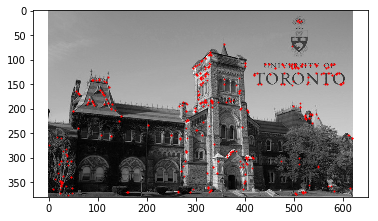

fks (643, 128) (76, 128)


IndexError: boolean index did not match indexed array along dimension 1; dimension is 1626 but corresponding boolean dimension is 643

In [67]:
path1 = 'img/uoft2.jpg'
path2 =  'img/uoft3.jpg'
fk1,xk1,fk2,xk2,pairs,phi = imgMatch(N=2,s=5,path1=path1,path2=path2,shrink=2,std=0.4,crt=0.8,num='max')

In [ ]:
fk1

# The fundamental Matrix

In [ ]:
idx = np.arange(pairs[0].shape[1])


In [ ]:
def hmg(x):
    n = x.shape[1]
    ones = np.ones(n)
    return np.vstack((x,ones))
        

In [ ]:
sqe_bin=1e20

for i in range(100000):
    idx1 = np.random.choice(idx,8)
    idx2 = np.random.choice(idx,8)

    x1 = pairs[0][0][idx1]
    y1 = pairs[0][1][idx1]

    #x1 -= (np.sum(x1)/x1.shape)
    #y1 -= (np.sum(y1)/y1.shape)
    
    x2 = pairs[1][0][idx2]
    y2 = pairs[1][1][idx2]
    
    #x2 -= (np.sum(x2)/x2.shape)
    #y2 -= (np.sum(y2)/y2.shape)

    A = np.vstack((x2*x1,x2*y1,x2,y2*x1,y2*y1,y2,x1,y1,np.ones(x2.shape)))

    U,S,V = np.linalg.svd(A.T)

    F_ = V[-1].reshape((3,3))

    U,S,V = np.linalg.svd(F_)
    S[-1]=0
    F = (U.dot(np.diag(S))).dot(V)
    
    e1 = np.sum((hmg(pairs[0][:2]).T.dot(F) - hmg(pairs[1][:2]).T)**2,axis=1)
    e2 = np.sum((hmg(pairs[1][:2]).T.dot(F) - hmg(pairs[0][:2]).T)**2,axis=1)
    sqe = np.sum(e1+e2)
    
    if sqe<sqe_bin:
        sol = F
        sqe_bin = sqe
        idxes = idx1
        bin_=e1+e2
print('Minimum error: {}'.format(sqe_bin))
        

In [ ]:
plt.hist(bin_)

In [ ]:
print('Image 1:')
im1 = plt.imread(path1)
im1 = np.mean(im1,axis=2)

print('\nImage 2:')
im2 = plt.imread(path2)
im2 = Reduce(np.mean(im2,axis=2),2)

plt.imshow(im1,**{'cmap':'gray'})

plt.scatter(pairs[0][:,idxes][0],pairs[0][:,idxes][1],color='red',s=5)
plt.show()

plt.imshow(im2,**{'cmap':'gray'})

plt.scatter(pairs[1][:,idxes][0],pairs[1][:,idxes][1],color='red',s=5)
plt.show()


# Garbage

In [ ]:
def conv2d_max(f,g,k=1,**kwargs):
    beg = time.time()
    w,h = g
    
    w = int(w)
    h = int(h)
    _,W,H = f.shape

    x_pad = int(0.5*((W-1)*k-W+w))
    y_pad = int(0.5*((H-1)*k-H+w))

    f_pad = np.pad(f,((0,0),(x_pad,x_pad),(y_pad,y_pad)),mode='constant')

    I=[]
    for m in range(int(f_pad.shape[2]-w)+1):        
        for n in range(int(f_pad.shape[1]-h+1)):
            
            w = f_pad[:,n:n+3,m:m+3]
           
           
            w_max = w[1,1,1]
            w[1,1,1]=0
            
            if (np.max(w)< w_max)|(np.min(w)>w_max)==True:
                I.append(1)
            else:
                I.append(0)
    end = time.time()
    print('Non-max sup execution time: {}'.format(end-beg))
    return np.array(I).reshape(H,W)


def conv2d_loop(f,g,k=1,**kwargs):
    w,h = g.shape
    W,H = f.shape

    g = np.rot90(g,2)
    

    x_pad = int(0.5*((W-1)*k-W+w))
    y_pad = int(0.5*((H-1)*k-H+w))

    f_pad = np.pad(f,((y_pad,y_pad),(x_pad,x_pad)),mode='constant')

    I=[]
    for m in range(int(f_pad.shape[0]-w)+1):
        for n in range(int(f_pad.shape[1]-h+1)):
            fg = np.multiply(f_pad[m:m+w,n:n+h],g)
            sum_fg = np.sum(fg,axis=(0,1))
            I.append(sum_fg)

    return np.array(I).reshape(W,H)

def blur(im,sigma,k,h=5,w=5,stride=1):
    g = GaussianFilter(h,w,k*sigma)
    return conv2d_loop(im,g,stride)

In [ ]:
bins = np.arange(0,360,45)##hist =np.hstack(hist)*math.pi/180

hist=[]
for k in range(Imag.shape[-1]):
    contrib = np.zeros_like(bin)
    W = GaussianFilter(16,16,xk[3,i])
    W = split_matrix(W)
    count = np.zeros_like(bins)
    fk=[]
    for p in range(Imag.shape[-2]):
        P = Irho[:,:,p,k]
        D = Imag[:,:,p,k]#*W[:,:,p]
       


        O = np.argmin((P[:,:,np.newaxis]-bins)**2,axis=2).astype(int)
        

        for i in range(P.shape[0]):
            for j in range(P.shape[1]):
                count[O[i,j]]+=D[i,j]
        
        fk.append(count)

    fk = np.hstack(fk)
    hist.append(fk/np.linalg.norm(fk))


def conv2d_max(f,g,k=1,**kwargs):
    C,H,W = f.shape
    h,w = g

    x_pad = int(0.5*((W-1)*1-W+w))
    y_pad = int(0.5*((H-1)*1-H+w))

    f_pad = np.pad(f,((0,0),(x_pad,x_pad),(y_pad,y_pad)),mode='maximum')

    k,i,j = get_im2col_indices_blur((1,3,H,W), h, w, p_x=x_pad,p_y=y_pad, stride=1)

    cols = f_pad[k,i,j]
    
    xc = int((h*w-1)/2) 
    cols = np.delete(cols,(xc,xc+h*w,xc+2*h*w),0)
    
    cond = ((f[1,:,:].flatten() > 
             np.max(cols,axis=0))|(f[1,:,:].flatten() < 
                                   np.min(cols,axis=0)))&(np.abs(f[1,:,:].flatten())>0.03)

    return cond.reshape(H,W).T



In [ ]:
def get_patch(im,kp,h=9,w=9):
    h_ = int((h-1)/2)
    w_ = int((w-1)/2)
    im = np.pad(im,((h_,h_),(w_,w_)),'mean')
    mypks=kp[:2].astype(int).T
    patches=[]
    for i in mypks:
        p = im[i[1]:i[1]+h,i[0]:i[0]+w]
        patches.append(p)
        if p.shape[0]==0:
            print(i)
    
    return np.dstack(patches)

In [ ]:
def SIFT(im,N=4,std=1.6,s=4,display=False):
 
    kp = []
    sig=[]
    pyramid = {}

    for n in range(N):
        octa,stacks,sigma = octave(im/255,n+1,sigma=std,s=s)

        count = 1
        for i,stack in enumerate(stacks):   

            xk = np.argwhere(conv2d_max(stack,(3,3)))

            if display==True: print('Total of {} kps for a scale equal to  {}'.format(xk.shape[0],sigma[i]))
            sig.append(np.ones(xk.shape[0])*sigma[i])

            xk = np.vstack((xk.T,np.ones(xk.shape[0])*count))
            kp.append(xk)
            count+=1

        deltas,keep = refine_location_prune(im,octa,xk)
        pyramid[n]= octa,xk[:,keep]
        if display==True: print('Remaining kps after prunning: {}'.format(np.sum(keep)))
    kp = np.hstack(kp)
    rho = HOG(im,kp)
    sig = np.hstack(sig)
    xk = np.vstack((kp,sig,rho))
    return xk,deltas


In [ ]:
def conv2d_max(f,g,k=1,**kwargs):
    f = f[:,np.newaxis,:,:]
    f = np.repeat(f,3,axis=1)
    N,_ ,H,W = f.shape
    h,w = g

    x_pad = int(0.5*((W-1)*1-W+w))
    y_pad = int(0.5*((H-1)*1-H+w))

    f_pad = np.pad(f,((0,0),(0,0),(x_pad,x_pad),(y_pad,y_pad)),mode='maximum')

    k,i,j = get_im2col_indices_conv2d_max((N,3,H,W), h, w, p_x=x_pad,p_y=y_pad, stride=1)

    cols = f_pad[:,k,i,j]
       
    xc = int((h*w-1)/2) 
    cols = np.delete(cols,(xc,xc+h*w,xc+2*h*w),1)
    
    cond = ((f[:,1,:,:].flatten() > 
             np.max(cols,axis=1).flatten())|(f[:,1,:,:].flatten() < 
                                   np.min(cols,axis=1).flatten()))&(np.abs(f[:,1,:,:].flatten())>0.03)

    return cond.reshape(N,H,W).T

def refine_location_prune(im,pyr,kp):
    #pyr = pyramid[0]
    H,dx,J = get_deriv(pyr,kp)

    U,S,V = np.linalg.svd(np.moveaxis(H,2,0))
    S = S[:,:,np.newaxis]*np.diag(np.ones(3))
    A = np.linalg.inv(S)
    H_inv = np.matmul(np.matmul(A,S),V)
    deltas = np.squeeze(np.matmul(H_inv,np.moveaxis(dx,1,0)[:,:,np.newaxis]))
    

    if kp.shape[1]!=0:
        keep = harris(im,kp)
        return (deltas,keep)
    else:
        return (deltas,None)
    #return (deltas,None)
    
im = plt.imread('img/canny.jpeg')
im = np.mean(im,axis=2)
H,W = im.shape
if (H>1000)|(W>1000):
    im = Reduce(im,3)
    
octa,stacks,sigma = octave(im/255,1,sigma=0.3,s=4)

N,H,W=octa.shape

n = np.tile(np.arange(3),N-2) + np.repeat(np.arange(N-2),3)
pyr = octa[n,:,:].reshape((N-2,3,H,W))

xk = np.argwhere(conv2d_max(pyr,(3,3)))
xk = build_sig(xk,sigma)
    

def blur(im,sigma,h,w,stride=1,C=3):
    H,W = im.shape
    g = GaussianFilter(h,w,sigma).flatten()
    #g = np.tile(g,C)
    
    stride=1
    h_pad = int((H*(stride-1)-stride+h)/2)
    w_pad = int((W*(stride-1)-stride+w)/2)
    
    k,i,j = get_im2col_indices_blur((1,1,H,W), h, w, p_x=h_pad,p_y=w_pad, stride=1)
    
    im_padded = np.pad(im,((h_pad,h_pad),(w_pad,w_pad)),'mean')
    cols = im_padded[i,j]

    return cols.T.dot(g).reshape(H,W)